<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 18 - K-means clustering and Gaussian mixture models
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

In this lecture: 

- K-means clustering algorithm
- Gaussian mixture models

## Unsupervised Learning

So far we've discussed supervised learning whihc is learning when there are labels attached to a input. 

Unsupervised learning is when the data has no labels attached. 

<img align="center" src="img/supervised_vs_unsupervised.png" width="800px" style="padding:30px;border:thin solid white;"> 


### Unsupervised tasks

- **Dimensionality reduction** - We talked about the importance of this in last lecture. 
    - **Visualization** 
    - **Compression**

- **Clustering** - grouping "like" items together
    - **Classification** when mixed with smaller labeled dataset 
    
    
<img align="center" src="img/clustering_example.png" width="400px" style="padding:30px;border:thin solid white;"> 

## K-means clustering (general idea)

*Gratitude to Herman Kempar's excellent lectures on this topic

### Algorithm basic idea: 

First we have to determine the number of clusters we want to partition  the data into. Let's say there's $k$ clusters. 

**Starting work:** for each datapoint, randomly assign it to one of $k$ clusters. 

**For each iteration:**  

1. for each cluster $k = 1 \rightarrow K$
    - Calculate the cluster center $\mu_k$ as the mean of all the items assigned to the cluster $k$
    
2. for each data point $n = 1 \rightarrow N$
    - Assign the datapoint $x^{(n)}$ to the cluster with the closest center
    
**End when** the data assignments to each cluster stop beign updated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 1. Generate synthetic data with 3 clusters, 20 points each

def generate_data(centers, k=3, n=20, seed=42):
    np.random.seed(seed)
    data = []
    for cx, cy in centers[:k]:
        cluster = np.random.randn(n, 2) + np.array([cx, cy])
        data.append(cluster)
    return np.vstack(data)

# 2. Randomly assign initial clusters
def initialize_clusters(data, k):
    return np.random.randint(0, k, size=len(data))

# 3. Calculate centroids based on current assignments
def calculate_centroids(data, assignments, k):
    centroids = np.array([data[assignments == i].mean(axis=0) if np.any(assignments == i) else np.random.randn(2) for i in range(k)])
    return centroids

# 4. Update assignments based on closest centroid
def update_assignments(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# 5. Plot data points and centroids
def plot_clusters(data, assignments, centroids):
    k = centroids.shape[0]
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    plt.figure(figsize=(6, 6))
    for i in range(k):
        points = data[assignments == i]
        plt.scatter(points[:, 0], points[:, 1], c=colors[i % len(colors)], label=f'Cluster {i}')
        plt.scatter(centroids[i, 0], centroids[i, 1], c=colors[i % len(colors)], marker='x', s=100, linewidths=3)
    plt.title("K-means Clustering")
    plt.legend()
    plt.grid(True)
    plt.show()

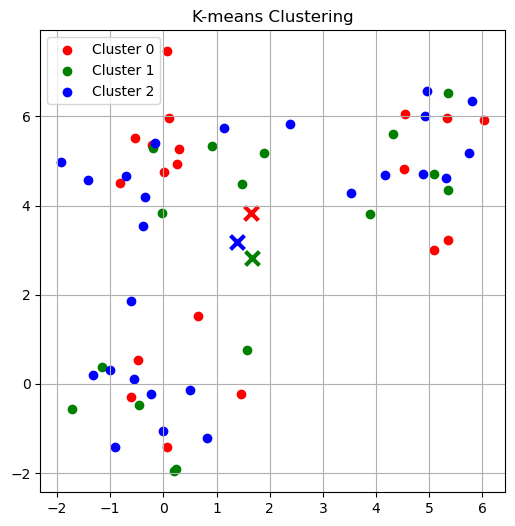

In [2]:
k=3
n=20
centers = [(0, 0), (5, 5), (0, 5)]
data = generate_data(n=n, k=k, centers=centers)
cluster_assignments = initialize_clusters(data, k)
centroids = calculate_centroids(data, cluster_assignments, k)
plot_clusters(data, cluster_assignments, centroids)

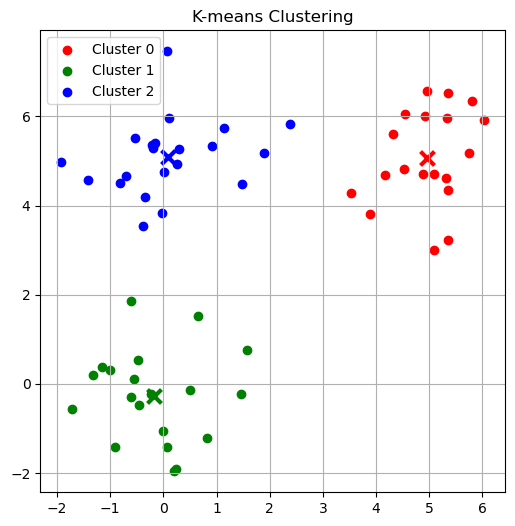

In [17]:
cluster_assignments = update_assignments(data, centroids)
plot_clusters(data, cluster_assignments, centroids)

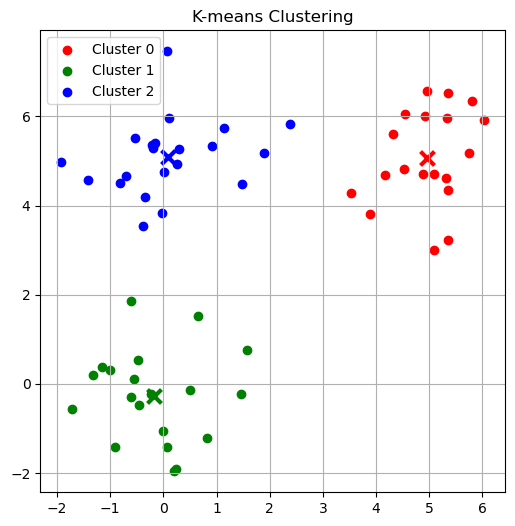

In [18]:
centroids = calculate_centroids(data, cluster_assignments, k)
plot_clusters(data, cluster_assignments, centroids)

## K-means clustering (technical notation)

Notation: 

- $C_k$ represents the set of indices of items assigned to cluster $k$ 
    - e.g. $C_4 = \left\{ 205, 12, 303 \right\}$ 
- $\vert C_k \vert$ is the number of items in the cluster
    - e.g. $\vert C_4 \vert = 3$

### Step 1: Calculate clusters: 
        
for each cluster k = 1 to $K$: 
    Calculate the cluster centroid $\mu_k$ as the mean of all the items assigned to cluster $k$
    
$\mu_k = \frac{1}{\vert C_k \vert} \Sigma_{i \in C_k} x^{\left(i\right)} $ 

### Step 2: Assign data to clusters: 
        
for each item  n = 1 to $N$: 
    Assign item $x^{(n)}$ to the cluster with the closest centroid
    
$\text{arg}_k\text{min} \vert\vert x^{(n)} - \mu_k \vert\vert^2  $ 

### Loss function:

For one cluster: Trying to optimize the distance between each of the items in a cluster to the centroid of the cluster. 

$\Sigma_{i \in C_k} \vert\vert x^{(i)} - \mu_k \vert\vert^2 $

But we need to do this for every cluster: 

$\Sigma^{K}_{k=1} \Sigma_{i \in C_k} \vert\vert x^{(i)} - \mu_k \vert\vert^2 $

but what is the loss a function of: 

$J\left(C_1, \ldots, C_k, \mu_1, \ldots, \mu_k \right) = \Sigma^{K}_{k=1} \Sigma_{i \in C_k} \vert\vert x^{(i)} - \mu_k \vert\vert^2 $


### Initialization leads to different solutions

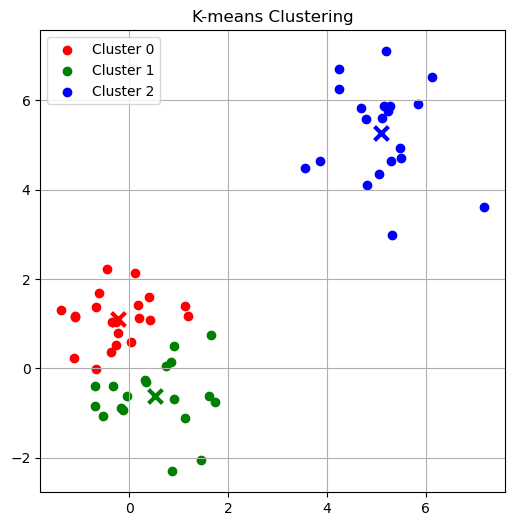

In [20]:
k=3
n=20
centers = [(0, 0), (5, 5), (0, 1)]
data = generate_data(n=n, k=k, centers=centers, seed=1) #### try with seed 7 and seed 1
cluster_assignments = initialize_clusters(data, k)
centroids = calculate_centroids(data, cluster_assignments, k)

change_flag=True
num_iters=10
i = 0
while change_flag==True:
    change_flag=False
    i=i+1
    if i>num_iters:
        break
    cluster_assignments_new = update_assignments(data, centroids)
    assignments_differ = any(a != b for a,b in zip(cluster_assignments_new, cluster_assignments))
    if assignments_differ:
        change_flag = True
    cluster_assignments = cluster_assignments_new
    centroids = calculate_centroids(data, cluster_assignments, k)

plot_clusters(data, cluster_assignments, centroids)


- A solution to this problem is running k_means multiple times and keeping the cluster values with the smallest loss

## Gaussian mixture models 

K-means clustering is pretty good at distinguishing between clusters that are spacially dintinct. 

But what if the clusters run into eachother? 

### Drawback of K-means algorithm

Let's look at some data where K-means might not be the best option: 

In [21]:
# -------------------------------------------------------------------------
# 1. Dataset Generation
# -------------------------------------------------------------------------

def generate_data(n_samples=300, random_state=42, plot_clusters=False, differentiated=True):
    """
    Generates a 2D dataset with two clusters.
    Both clusters overlap, providing a scenario where the GMM outperforms k-means.
    
    Optional plotting:
    - If 'plot_clusters' is True, displays the clusters.
    - If 'differentiated' is True, each cluster is plotted in a different color;
      otherwise, all points are plotted in gray.
    """
    np.random.seed(random_state)
    
    # Define means and covariance matrices for each cluster:
    mean1 = np.array([0, 0])
    cov1 = np.array([[10, 0], [0, 1]])  # Horizontal elongation
    mean2 = np.array([1, 1])
    cov2 = np.array([[1, 0], [0, 10]])  # Vertical elongation

    # Sample points from two multivariate normal distributions:
    X1 = np.random.multivariate_normal(mean1, cov1, n_samples)
    X2 = np.random.multivariate_normal(mean2, cov2, n_samples)
    
    # Stack both clusters into one dataset
    X = np.vstack((X1, X2))
    
    # Optional plotting of the clusters:
    if plot_clusters:
        plt.figure(figsize=(8, 6))
        if differentiated:
            plt.scatter(X1[:, 0], X1[:, 1], s=10, alpha=0.5, label='Cluster 1', color='blue')
            plt.scatter(X2[:, 0], X2[:, 1], s=10, alpha=0.5, label='Cluster 2', color='red')
        else:
            plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5, color='gray')
        
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title("Generated Clusters")
        if differentiated:
            plt.legend()
        plt.show()
        
    return X

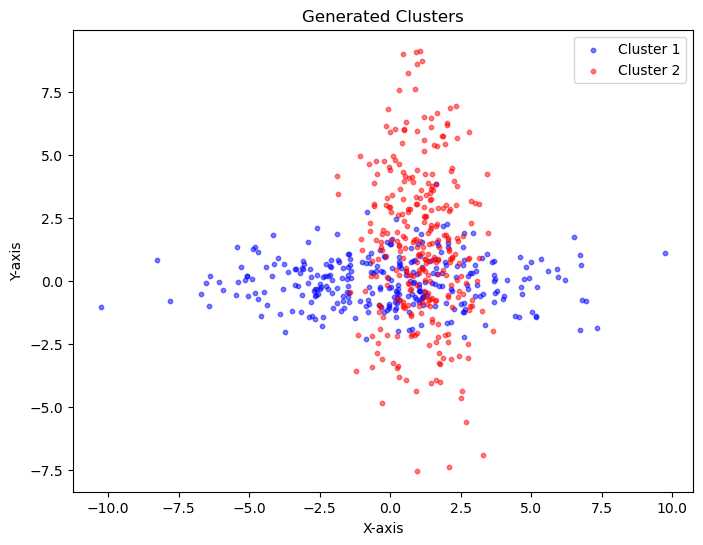

In [22]:
data_differentiated = generate_data(plot_clusters=True, differentiated=True)

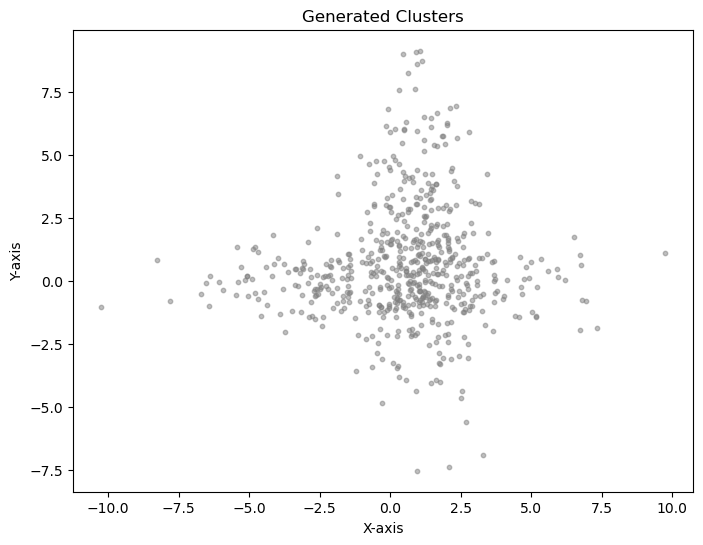

In [23]:
data_gray = generate_data(plot_clusters=True, differentiated=False)

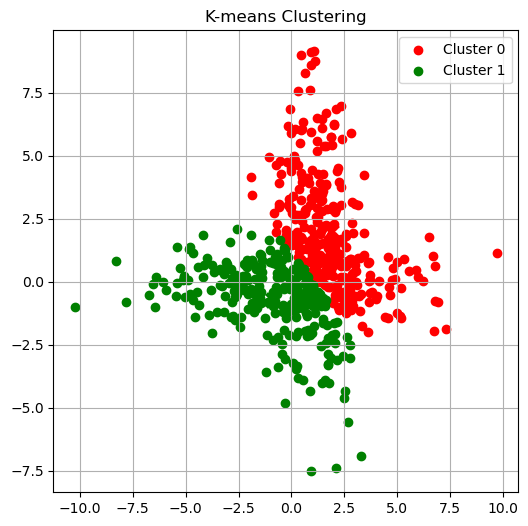

In [24]:
k=2
cluster_assignments = initialize_clusters(data_gray, k)
centroids = calculate_centroids(data_gray, cluster_assignments, k)

change_flag=True
num_iters=10
i = 0
while change_flag==True:
    change_flag=False
    i=i+1
    if i>num_iters:
        break
    cluster_assignments_new = update_assignments(data_gray, centroids)
    assignments_differ = any(a != b for a,b in zip(cluster_assignments_new, cluster_assignments))
    if assignments_differ:
        change_flag = True
    cluster_assignments = cluster_assignments_new
    centroids = calculate_centroids(data_gray, cluster_assignments, k)

plot_clusters(data_gray, cluster_assignments, centroids)

K-means is a **hard** clustering method - it will associate each point with only one cluster. 

Gaussian mixture model is a soft clustering method. Each datapoint has a probability distribution of what cluster it may belong to. 

<img align="center" src="img/3_gaussian-mixture-model.jpg" width="600px" style="padding:30px;border:thin solid white;"> 
[2]

## Gaussian mixture model equation


A Gaussian Mixture Model represents the probability density function of a dataset as:

$$
p(x) = \sum_{k=1}^{K} \pi_k\, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

- $\mathcal{N}(x \mid \mu_k, \Sigma_k)$: Gaussian density for the $k$-th component.
- $\pi_k$: Mixing coefficient for the $k$-th component.
- $K$: Total number of components.

#### Properties of Mixing Coefficients

1. **Non-negativity:**

   $$
   \pi_k \geq 0 \quad \text{for all } k.
   $$

2. **Normalization:**

   $$
   \sum_{k=1}^{K} \pi_k = 1.
   $$

These properties ensure that each mixing coefficient represents a valid probability, indicating the prior probability that a randomly chosen data point comes from the corresponding Gaussian component.


## Expectation-Maximization algorithm for Gaussian mixture model

### The Two Main Steps of the EM Algorithm

The EM algorithm comprises two alternating steps:

#### E-Step (Expectation Step)

In this step, the algorithm computes the "responsibilities" or the posterior probabilities that a data point $x^{(i)}$ belongs to each Gaussian component $k$. These responsibilities are denoted by $\gamma(z_{k}^{(i)})$ and are given by:

$$
\gamma(z_{k}^{(i)}) = \frac{\pi_k \, \mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \, \mathcal{N}(x^{(i)} \mid \mu_j, \Sigma_j)}
$$

- **Interpretation:**  
  $\gamma(z_{k}^{(i)})$ represents the probability (responsibility) that data point $x_i$ was generated by component $k$. This step “softly” assigns data points to the different Gaussian components based on current parameter estimates.

#### M-Step (Maximization Step)

In the M-Step, the parameters of the GMM (i.e., the mixing coefficients, means, and covariances) are updated to maximize the expected complete-data log-likelihood computed during the E-Step.

The update formulas are as follows:

1. **Update the Mixing Coefficients:**

   $$
   \pi_k = \frac{1}{N} \sum_{i=1}^{N} \gamma(z_{k}^{(i)})
   $$

   Here, $N$ is the total number of data points. This update computes the average responsibility for each component, effectively representing the proportion of the dataset assigned to component $k$.

2. **Update the Means:**

   $$
   \mu_k = \frac{\sum_{i=1}^{N} \gamma(z_{k}^{(i)}) \, x^{(i)}}{\sum_{i=1}^{N} \gamma(z_{k}^{(i)})}
   $$

   This weighted average recalculates the center of the data assigned to each component.

3. **Update the Covariance Matrices:**

   $$
   \Sigma_k = \frac{\sum_{i=1}^{N} \gamma(z_{k}^{(i)}) \, (x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^\top}{\sum_{i=1}^{N} \gamma(z_{k}^{(i)})}
   $$

   The covariance update computes the weighted spread of the data around the updated mean for each component.

### The Iterative Process

The EM algorithm proceeds as follows:

1. **Initialization:**  
   Choose initial values for the parameters $\{ \pi_k, \mu_k, \Sigma_k \}$, often by random assignment or using a clustering algorithm like K-means.

2. **Iterative Updates:**  
   - **E-Step:** Calculate the responsibilities $\gamma(z_{ik})$ for every data point $x_i$ and component $k$.
   - **M-Step:** Update the parameters using the formulas above.

3. **Convergence:**  
   The algorithm repeats these two steps until convergence. Convergence can be determined by:
   - The change in the log-likelihood of the data falling below a threshold.
   $$
    \log \mathcal{L} = \sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x^{(i)} \mid \mu_k, \Sigma_k) \right)
    $$ 
    (Want to maximize log-likelihood (or minimize $-\log \mathcal{L}$))
   - The changes in parameter estimates becoming sufficiently small.
   - A maximum number of iterations being reached.

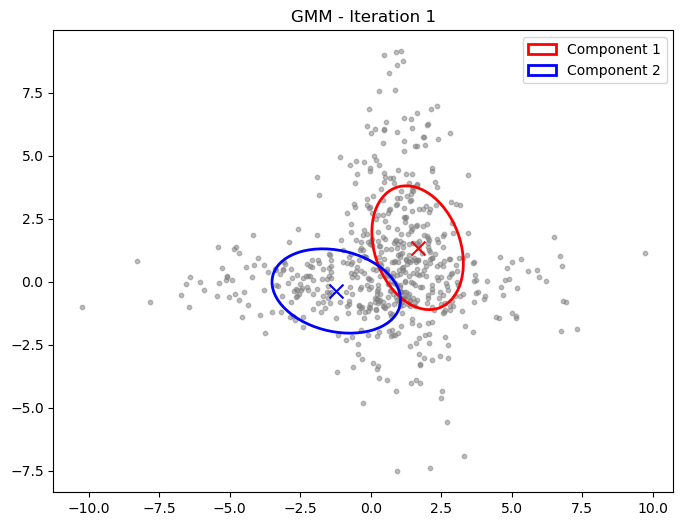

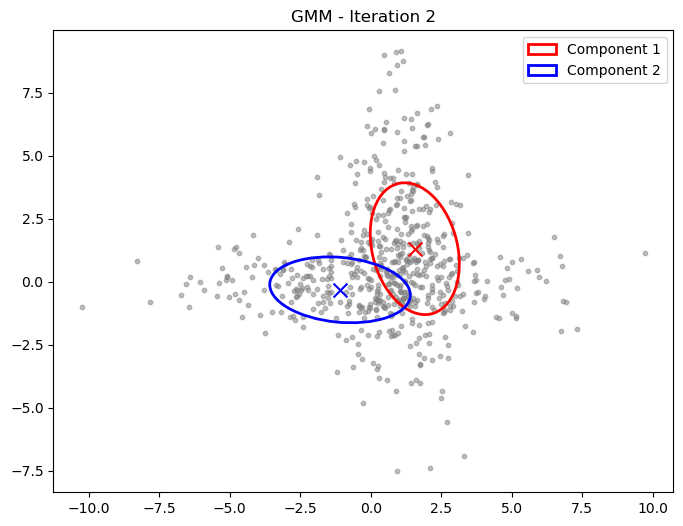

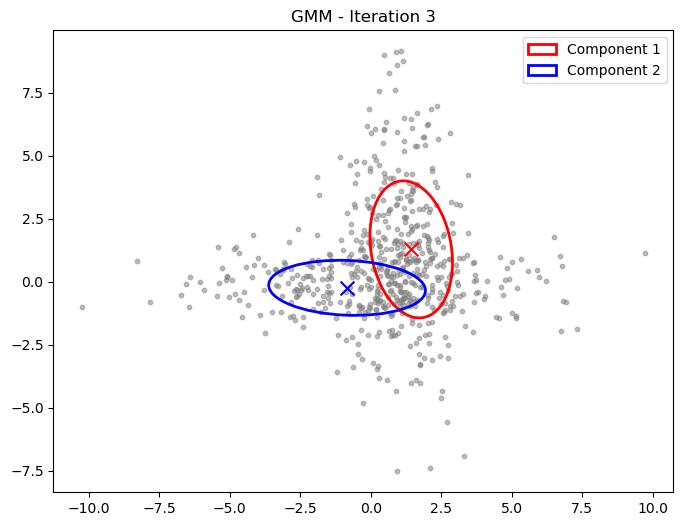

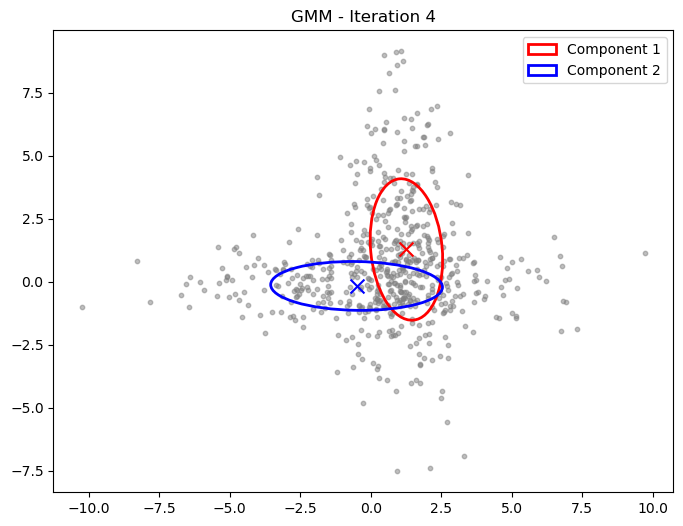

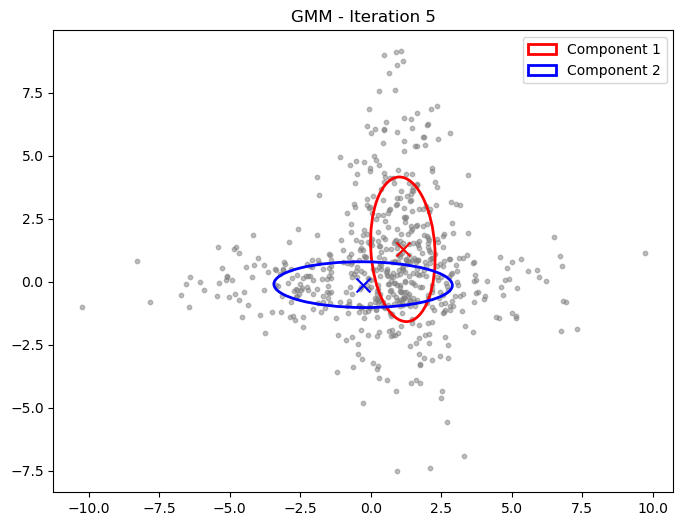

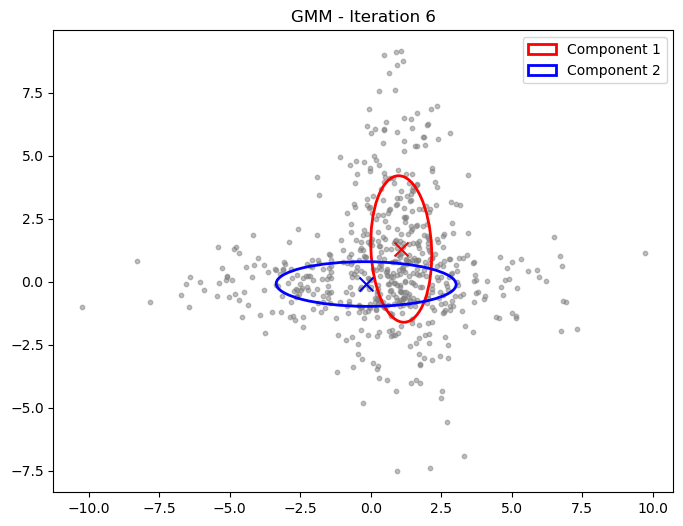

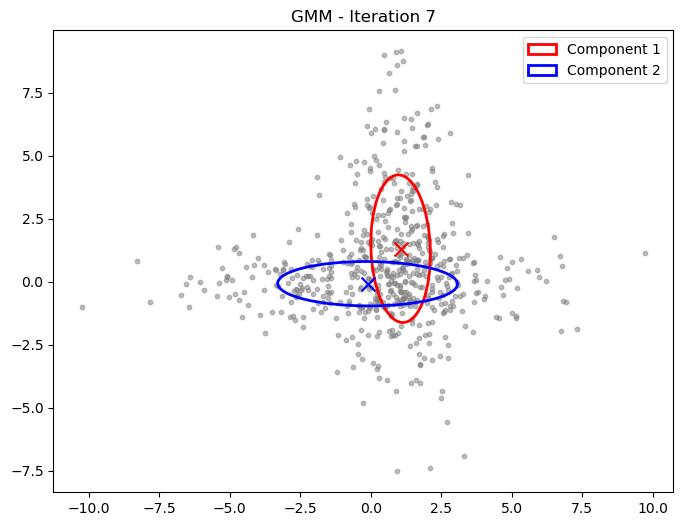

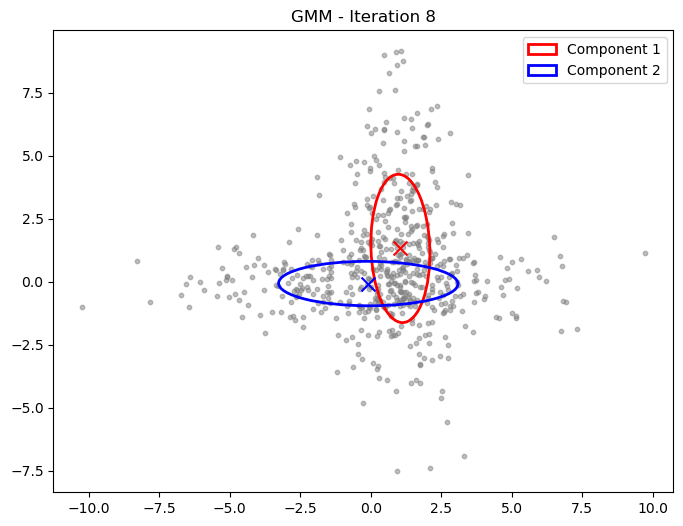

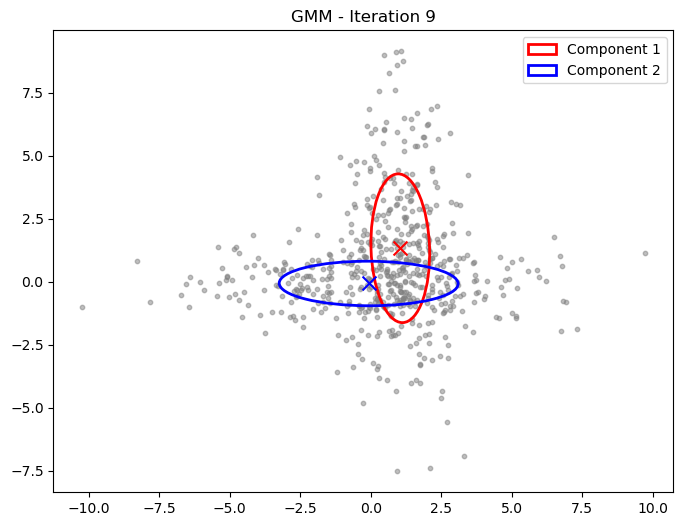

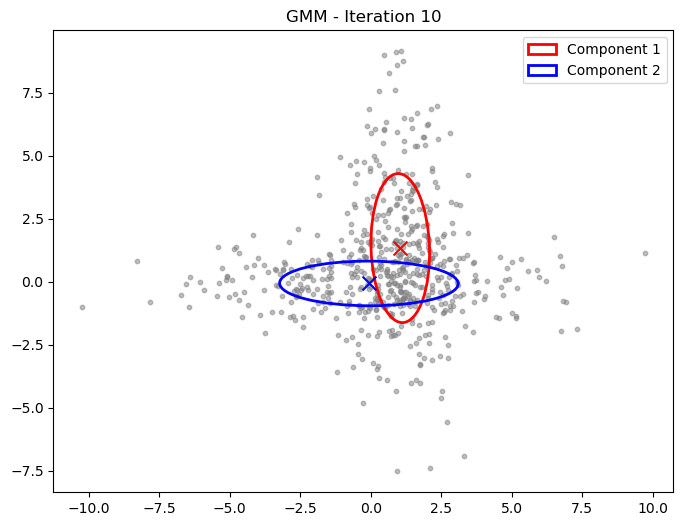

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# -------------------------------------------------------------------------
# 2. Plotting Function for Data and Gaussian Components
# -------------------------------------------------------------------------
def plot_gmm(X, means, covs, iteration, ax=None):
    """
    Plots the dataset along with the current Gaussian components.
    
    - Data points are plotted in grey.
    - The current means are marked with 'x' in different colors.
    - Each Gaussian's 1-standard-deviation ellipse is drawn.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the dataset
    ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5, color='grey')
    
    # Define colors for each component (you can customize these)
    colors = ['red', 'blue']
    for k, (mean, cov) in enumerate(zip(means, covs)):
        # Mark the mean
        ax.scatter(mean[0], mean[1], c=colors[k], s=100, marker='x')
        
        # Calculate eigenvalues and eigenvectors for the covariance matrix
        vals, vecs = np.linalg.eigh(cov)
        # Sort the eigenvalues in descending order for the correct ellipse shape
        order = vals.argsort()[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        
        # The ellipse's width and height represent 2*sqrt(eigenvalue)
        width, height = 2 * np.sqrt(vals)
        ellip = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                        edgecolor=colors[k], facecolor='none', lw=2, label=f'Component {k+1}')
        ax.add_patch(ellip)
    
    ax.set_title(f'GMM - Iteration {iteration}')
    ax.legend()
    plt.show()

# -------------------------------------------------------------------------
# 3. Gaussian PDF and One EM Iteration
# -------------------------------------------------------------------------
def gaussian_pdf(x, mean, cov):
    """
    Computes the multivariate normal density for a given point x.
    """
    d = x.shape[0]
    norm_const = 1.0 / (np.power((2*np.pi), d/2) * np.sqrt(np.linalg.det(cov)))
    diff = (x - mean).reshape(-1, 1)
    exponent = -0.5 * (diff.T @ np.linalg.inv(cov) @ diff)[0, 0]
    return norm_const * np.exp(exponent)

def gmm_em_step(X, weights, means, covs):
    """
    Performs one iteration of the EM algorithm for the GMM.
    E-step: Compute responsibilities for each data point.
    M-step: Update weights, means, and covariances based on the responsibilities.
    
    Returns updated weights, means, covs, and the responsibilities matrix.
    """
    n_samples = X.shape[0]
    n_components = len(weights)
    # E-step: Compute responsibilities (soft assignments)
    responsibilities = np.zeros((n_samples, n_components))
    for i in range(n_samples):
        for k in range(n_components):
            responsibilities[i, k] = weights[k] * gaussian_pdf(X[i], means[k], covs[k])
        responsibilities[i, :] /= np.sum(responsibilities[i, :])
    
    # M-step: Update parameters using the responsibilities
    new_weights = np.zeros(n_components)
    new_means = []
    new_covs = []
    
    for k in range(n_components):
        Nk = np.sum(responsibilities[:, k])
        new_weights[k] = Nk / n_samples
        # Update mean: weighted average of data points
        new_mean = np.sum(responsibilities[:, k].reshape(-1, 1) * X, axis=0) / Nk
        new_means.append(new_mean)
        # Update covariance: weighted spread of the data around the new mean
        diff = X - new_mean
        new_cov = np.dot((responsibilities[:, k].reshape(-1, 1) * diff).T, diff) / Nk
        new_covs.append(new_cov)
    
    return new_weights, np.array(new_means), new_covs, responsibilities

# -------------------------------------------------------------------------
# 4. Running the GMM Demo
# -------------------------------------------------------------------------
def run_gmm_demo(n_iterations=10):
    """
    Generates the dataset, initializes the GMM parameters, and then
    iteratively runs the EM algorithm while plotting the progress.
    """
    # Generate the dataset
    X = generate_data()
    n_components = 2  # We know we have 2 clusters

    # Initialize GMM parameters
    weights = np.array([0.5, 0.5])
    # For means, randomly select two data points from the dataset
    np.random.seed(0)
    indices = np.random.choice(X.shape[0], n_components, replace=False)
    means = X[indices]
    # Initialize covariances with the overall covariance of the dataset
    overall_cov = np.cov(X, rowvar=False)
    covs = [overall_cov for _ in range(n_components)]
    
    # Iterate the EM algorithm and plot the outcome at each iteration
    for iteration in range(n_iterations):
        weights, means, covs, responsibilities = gmm_em_step(X, weights, means, covs)
        plot_gmm(X, means, covs, iteration + 1)

# Run the demonstration
run_gmm_demo(n_iterations=10)

## That's it for today

- Next time we'll discuss generative adversarial networks
- Project descriptions have been posted (see Piazza)

## References

[1] Kamper, Herman "K-means clustering [lectures]" - https://youtu.be/_Tf1Vi4s7Ec&list=PLmZlBIcArwhMfNuMBg4XR-YQ0QIqdHCrl

[2] Carrasco, Oscar "Gaussian Mixture Model Explained" - https://builtin.com/articles/gaussian-mixture-model
